VQE (variational quantum eigensolver) es un algoritmo que sirve para encontrar una cota superior para la mínima energía de un Hamiltoniano, resultando ser una herramienta bastante útil en la busqueda de una aproximación al estado basal, asociado esta mínima energía. Dicho de otro modo, VQE busca una solución al problema

\begin{equation}
 \min_{|\psi\rangle}\frac{
 \langle\psi|\hat{H}|\psi\rangle}{\langle\psi|\psi\rangle}
\end{equation}

lo que significa que se busca un estado $|\psi\rangle$ que minimice la energía. Para resolver este problema mediante el uso de circuitos cuánticos necesitamos aprender dos cosas 

1) Ser capaces de generar el estado $|\psi\rangle$ en un circuito cuántico paramétrico, y
2) medir el valor de expectación del hamiltoniano $\hat{H}$ en este estado.

El primer punto se logra proponiendo un ansatz que parametrice el estado usando compuertas cuánticas de la forma $|\psi({\theta})\rangle = U({\theta})|0\rangle$. Un ejemplo de tal anzats se puede encontrar en la siguiente imagen

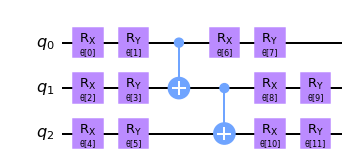

Con respecto al segundo punto, los hamiltonianos usualmente trabajados con este métodos son combinaciones lineales de productos tensoriales de operadores de Pauli, y estos pueden ser directamente medidos en un circuito usando las compuertas que permiten evaluar el valor de expectación de los respectivos operadores de Pauli. Por ejemplo, consideremos el siguiente hamiltoniano de tres qubits
\begin{equation}
\hat{H} = \sigma_Y\otimes I\otimes\sigma_X + \sigma_X \otimes\sigma_Y\otimes \sigma_Z.
\end{equation}
Luego, el circuito que permite medir el primer término del valor de expectación de $\hat{H}$ en el estado $|\psi(\theta)\rangle$ es
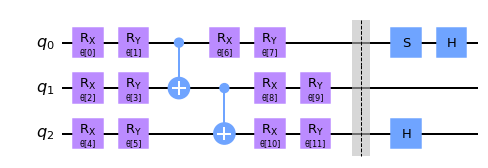
y el segundo término se puede medir usando 
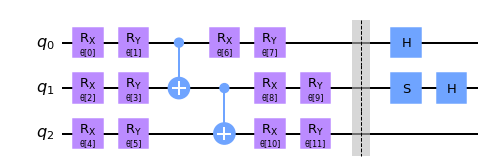

Así, medir el valor esperador del hamiltoniano en el estado $|\psi(\theta)\rangle$ consite en medir $N$ circuitos distintos, cada uno correspondiente a la composición del ansatz junto con la compuerta que permita medir la expectacion del $N-$ésimo operador de Pauli del Hamiltoniano.


Por lo tanto VQE consiste en la secuencia de pasos:
- Evaluar el circuito con un conjunto de parametros $\theta$ para medir la energía en el estado $|\psi(\theta)\rangle$
- Procesar las mediciones en un computador clásico para encontrar un nuevo conjunto de parámetros que disminuyan la energía obtenida
- Repetir los pasos anteriores con el nuevo conjunto de parámetros hasta que se alcance el punto deseado 
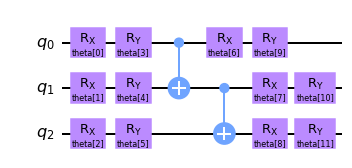

Con el fin de medir valores esperados de hamiltanianos usaremos el módulo OpFlow de qiskit, el cual provee clases que representan estados, operadores, sumas de operadores y productos tensoriales por lo que nos será de gran utilidad en el momento de escribir hamiltonianos de forma sencilla y eficaz. Además, obtener las compuertas cuánticas que permiten medir el valor esperado de los operadores que componen el hamiltoniano es una tarea simple usando estas herramientas, así como combinarlas con el ansatz y posteriormente usar circuitos para finalmente medir.

A modo de introducción, OpFlow trata tanto a estados como a operadores dentro de una gran clase llamada `OperatorBase`, sin embargo esta clase cuenta con una amplia gama de sub-clases que permiten diferenciar entre estados y operadores e incluso realizar distinciones más finas (por ejemplo si un operador es de Pauli, o si un estado es generado por un circuito).

Así, partimos por cargar este paquete y mostrar algunos operadores

In [1]:
import qiskit.opflow as of
import numpy as np
X = of.X #Pauli X
Y = of.Y #Pauli Y
Z = of.Z #Pauli Z
I = of.I #Identidad
H = of.H #Hadamard
S = of.S #S Gate

print(type(Y))
print(type(S))

<class 'qiskit.opflow.primitive_ops.pauli_op.PauliOp'>
<class 'qiskit.opflow.primitive_ops.circuit_op.CircuitOp'>


Las operaciones de suma de operadores y multiplicación por un escalar puden ser aplicadas de la forma usual, mientras que la multiplicación entre operadores (o composición) de OpFlow es dada por `@` y el producto tensorial por `^`.

In [2]:
# Ejemplos

# Hamiltonianos de uno y dos qubits
ej_ham_1q = X + 3*Y + Z/2
ej_ham_2q = 0.5*X^X
print(ej_ham_1q)
print("========================")

# Un operador evolución de 2 qubits
ev_op_2q = (H@X)^(S@H)
#Detalle, fijarse el orden de los qubits
print(ev_op_2q)

1.0 * X
+ 3.0 * Y
+ 0.5 * Z
     ┌───┐┌───┐
q_0: ┤ H ├┤ S ├
     ├───┤├───┤
q_1: ┤ X ├┤ H ├
     └───┘└───┘


**Ejercicio 1**
- Escriba el hamiltoniano
\begin{equation}
H = (X\otimes X) + 2 (Y \otimes Y) -1.5(Z \otimes Z) + 0.5(I\otimes Z)
\end{equation}
y llamelo `mi_hamiltoniano`, luego coloque print para ver el resultado. Además muestre el resultado en pantalla de `mi_hamiltoniano.eval()`

Es importante observar que los operadores de OpFlow (y sus objetos en general) son de cierta forma etiquetas con ciertos atributos, como por ejemplo el coeficiente, el circuito asociado, o el tipo de operador. Para conocer cualquier valor númerico siempre es necesario aplicar el método `.eval()` sobre estos objetos, pues es la instrucción de evaluar las ordenes especificadas por estos objetos.

In [3]:
# Solucion
mi_hamiltoniano = (X^X) + 2*(Y^Y) -1.5* (Z^Z)+0.5*(I^Z)
print(type(mi_hamiltoniano))

<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>


OpFlow también permite operar con objetos tipo estado, y estos pueden ser construidos con `StateFn`. Cabe notar que todas las operaciones vistas previamente son aplicables a estos objetos (sin embargo hay que tener cuidado con `@`, veremos esto un poco más adelante)

In [4]:
#Distintas formas de construir un estado


#definidos a través de un vector 
state2 = of.StateFn( [1 , 1] )/np.sqrt(2)

# OpFlow también tiene definidos ciertos estados, como por ejemplo
state1 = of.Plus

# se pueden crear desde un circuito de QuantumCircuit
# el circuito está iniciado en el estado "0"
from qiskit import QuantumCircuit
qc = QuantumCircuit(1)
qc.h(0)
state3 = of.StateFn(qc)


**Ejercicio 2**

- Compare `H`, `state3` y los tipos de ambas variables.

- Use el método `.eval()` en `state3`y `H` y ponga print para comparar.

- Intente componer `state3` con `state2`, vea cual es el error.

debe darse cuenta que si bien ambos objetos contienen el mismo circuito, sus evaluaciones son distintas, puesto que `H.eval()` es la matriz de Hadamard, mientras 
`state3.eval()` es una un vector que corresponde al resultado de colocar el estado $|0\rangle$ como estado inicial del circuito



In [5]:
# Solucion

print( type(H) )
print( type(state3) )

print("############################")

print(H)
print(state3)

print("############################")

print(H.eval())
print(state3.eval())

state3@state2

<class 'qiskit.opflow.primitive_ops.circuit_op.CircuitOp'>
<class 'qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn'>
############################
   ┌───┐
q: ┤ H ├
   └───┘
CircuitStateFn(
   ┌───┐
q: ┤ H ├
   └───┘
)
############################
Operator([[ 0.70710678+0.j,  0.70710678+0.j],
          [ 0.70710678+0.j, -0.70710678+0.j]],
         input_dims=(2,), output_dims=(2,))
VectorStateFn(Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,)))
Traceback (most recent call last):
  Input In [5] in <cell line: 16>
    state3@state2
  File /opt/conda/lib/python3.8/site-packages/qiskit/opflow/mixins/star_algebra.py:107 in __matmul__
    return self.compose(other)
  File /opt/conda/lib/python3.8/site-packages/qiskit/opflow/state_fns/circuit_state_fn.py:172 in compose
    raise ValueError(
ValueError: Composition with a Statefunctions in the first operand is not defined.

Use %tb to get the full traceback.


OpFlow está diseñado para que su escritura no sea muy distinta del álgebra lineal y por lo tanto realizar realizar operaciones entre estados y operadores es relativamente sencillo. Realizar cálculos del tipo $U|\psi\rangle$ se reduce a escribir en `U @ psi`, por otro lado calcular el traspuesto conjugado de un estado
$|\psi\rangle^\dagger = \langle\psi|$ se traduce a `psi.adjoint()` (o equivalentemente `~psi`). Todas estas herramientas en conjunto nos permiten realizar todas las operaciones elementales del álgebra lineal

**Ejercicio 3**

Use `QuantumCircuit` para construir los circuitos que generan los estados
\begin{align*}
|-\rangle &= \frac{1}{\sqrt{2}}(|0\rangle -  |1\rangle)\\
|r\rangle &= \frac{1}{\sqrt{2}}(|0\rangle + i|1\rangle)
\end{align*}
y con ellos:
- Use `StateFn` sobre ellos para generar estados de OpFlow.
- Usando el operador `@` para multiplicación entre objetos de OpFlow muestre en pantalla la evolución de estos estados generada por el operador $U = XHS$, es decir $U|\psi\rangle$
- Use el método `.adjoint()` para poder calcular el producto interno $\langle r|-\rangle$ y muetre en pantalla el resultado.

(no se olviden de usar el método `.eval()` para obtener resultados númericos)

In [6]:
#Solución


#parte 1
mstate = QuantumCircuit(1)
mstate.x(0)
mstate.h(0)

rstate = QuantumCircuit(1)
rstate.h(0)
rstate.s(0)

minus = of.StateFn( mstate ) 
right = of.StateFn( rstate ) 

#parte 2
U = X@H@S

minus_ev = U @ minus
right_ev = U @ right

print( "evolución -={}".format(minus_ev.eval()) )
print( "evolucion r={}".format(right_ev.eval())  )

#parte 3
inner = right.adjoint() @ minus

print( "producto interno={}".format(inner.eval()) )

print( minus.eval() )


evolución -=VectorStateFn(Statevector([0.5+0.5j, 0.5-0.5j],
            dims=(2,)))
evolucion r=VectorStateFn(Statevector([1.-1.22e-16j, 0.+0.00e+00j],
            dims=(2,)))
producto interno=(0.49999999999999983+0.4999999999999999j)
VectorStateFn(Statevector([ 0.70710678-8.7e-17j, -0.70710678+8.7e-17j],
            dims=(2,)))


Habiendo dominado las herramientas más básicas de OpFlow ahora procederemos hacia el primer paso de este taller; medir la energía de un estado. En el siguiente ejercicio veremos como calcular la energía del hamiltoniano `mi_hamiltoniano` en un estado de Bell de forma teórica de dos maneras:
- Usando lo previamente aprendido para calcular $\langle\psi|\hat{H}|\psi\rangle$

- Usado la opción `is_measurement=True` de `StateFn`, que especifica que en realidad se está trabajando con un operador de medición. Esta opción nos será especialmente útil a la hora de evaluar hamiltonianos en un circuito, pues dentro de sus atributos están las ordenes necesarias para evaluarlo en un circuito cuántico.

 **Ejercicio 4**

- Escriba un circuito de Bell usando `QuantumCircuit` para generar el estado 
$$|\Phi_+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$
y use `StateFn` sobre ese estado para construir un estado de opflow.

- Ocupe las operaciones previamente vistas y el hamiltoniano `mi_hamiltoniano` para calcular el valor esperado de `mi_hamiltoniano` en el estado de Bell

- Ocupe la `StateFn` en `mi_hamiltoniano` con la opción `is_measurement = True`
para crear un operador de medición y luego componga con el estado de Bell para medir el valor esperado de la energía, llame a toda esta composición `expected_energy_state`. Compare con el resultado anterior.

Este último paso lo que hace es indicar que `mi_hamiltoniano` es un observable y por lo tanto sigue al momento de evaluar sigue las indicaciones necesarias para calcular su valor de expectación.



In [7]:
#Solucion

# Parte 1
bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)
bell_circuit.cx(0,1)

bell_state =  of.StateFn( bell_circuit )

# Parte 2
expected_energy = ~bell_state @ mi_hamiltoniano @ bell_state


# Parte 3
expected_energy_state = of.StateFn(mi_hamiltoniano , is_measurement = True) @ bell_state
# expected_energy = (~of.StateFn(mi_hamiltoniano)).eval( bell_state )
# expected_energy = of.StateFn( mi_hamiltoniano ).adjoint() @bell_state
print("Comparación")
print(expected_energy)

print(expected_energy_state)

print(expected_energy_state.eval().real)


Comparación
ComposedOp([
  CircuitMeasurement(
            ┌───┐
  q_0: ──■──┤ H ├
       ┌─┴─┐└───┘
  q_1: ┤ X ├─────
       └───┘     
  ),
  1.0 * XX
  + 2.0 * YY
  - 1.5 * ZZ
  + 0.5 * IZ,
  CircuitStateFn(
       ┌───┐     
  q_0: ┤ H ├──■──
       └───┘┌─┴─┐
  q_1: ─────┤ X ├
            └───┘
  )
])
ComposedOp([
  OperatorMeasurement(1.0 * XX
  + 2.0 * YY
  - 1.5 * ZZ
  + 0.5 * IZ),
  CircuitStateFn(
       ┌───┐     
  q_0: ┤ H ├──■──
       └───┘┌─┴─┐
  q_1: ─────┤ X ├
            └───┘
  )
])
-2.4999999999999996


Aprendido todo esto, llego la hora de por fin usar circuitos cuánticos para evaluar nuestas expresiones, para eso haremos uso de las funciones `PauliExpectation().convert` y `CircuitSampler().convert` contenidas en OpFlow.

`PauliExpectation().convert` reconoce cuando en una medición hay operadores de Pauli y prosigue a añadir al circuito del estado en medición las compuertas correspondientes para medir el operador de Pauli.

`CircuitSampler(quantum_instance).convert` es una función que evalua los circuitos que estén presentes en una medición de OpFlow en la instancia cuántica `quantum_instance`. 
El retorno de la función es una medición de OpFlow que contiene el operador que se estaba midiendo sin cambiarlo y los resultados de las mediciones de los circuitos codificadas en un vector tipo estado. De esta manera al aplicar el método `.eval()` sobre el objeto resultante permite obtener el valor esperador del operador.

**Ejercicio 5**


- Aplique la función `PauliExpectation().convert` sobre `expected_energy_state` y muestre el resultado

- Cargue el simulador cuántico `qasm_simulator` como `quantum_instance`.

- Use la función `CircuitSampler(quantum_instance).convert` y muestre en pantalla el resultado para analizarlo. Finalmente aplique el método `.eval()` sobre este objeto para obtener el valor esperado

In [8]:
# Parte 1
pauli_circs = of.PauliExpectation().convert( expected_energy_state )
print( "resultado de PauliExpectation={}".format(pauli_circs) )
print("===============================================================")
# Parte 2
from qiskit import Aer
from qiskit.utils import QuantumInstance
quantum_instance = QuantumInstance(  Aer.get_backend("qasm_simulator"),
                                 shots = 2**7,
                                 )
# Parte 3
sampler = of.CircuitSampler(quantum_instance).convert( pauli_circs )
results = sampler.eval()
print( "resultado de circuitsampler = {}".format( sampler ) )
print("==============================================================")
print("La energía es {}".format(results.real))

resultado de PauliExpectation=SummedOp([
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    CircuitStateFn(
         ┌───┐     ┌───┐
    q_0: ┤ H ├──■──┤ H ├
         └───┘┌─┴─┐├───┤
    q_1: ─────┤ X ├┤ H ├
              └───┘└───┘
    )
  ]),
  ComposedOp([
    OperatorMeasurement(2.0 * ZZ),
    CircuitStateFn(
         ┌───┐     ┌─────┐┌───┐
    q_0: ┤ H ├──■──┤ Sdg ├┤ H ├
         └───┘┌─┴─┐├─────┤├───┤
    q_1: ─────┤ X ├┤ Sdg ├┤ H ├
              └───┘└─────┘└───┘
    )
  ]),
  ComposedOp([
    OperatorMeasurement(-1.5 * ZZ
    + 0.5 * IZ),
    CircuitStateFn(
         ┌───┐     
    q_0: ┤ H ├──■──
         └───┘┌─┴─┐
    q_1: ─────┤ X ├
              └───┘
    )
  ])
])


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


resultado de circuitsampler = SummedOp([
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    DictStateFn({'11': 0.7234898064243891, '00': 0.6903350635742038})
  ]),
  ComposedOp([
    OperatorMeasurement(2.0 * ZZ),
    DictStateFn({'10': 0.6959705453537527, '01': 0.7180703308172536})
  ]),
  ComposedOp([
    OperatorMeasurement(-1.5 * ZZ
    + 0.5 * IZ),
    DictStateFn({'11': 0.7447734554883115, '00': 0.667317390751957})
  ])
])
La energía es -2.5546875


Ahora que aprendimos lo básico sobre operadores y estados en OpFlow procederemos a crear un estado ansatz. Los estados ansatz están caracterizados por secuencias de capas de compuertas paramétricas de un qubit como por ejemplo $Rx(\theta_1)R_y(\theta_2)$, las cuales se repiten un cierto número de veces, y entre cada repetición se encuentra una compuerta que entrelaza los qubits. 


**Ejercicio 6**

1) Escriba una función llamada `mi_ansatz( nqbits, reps , npars )` que genere un circuito ansatz para un número arbitrario de qubits y repeticiones usando `QuantumCircuit`, tome la siguiente imagen como referencia (3 qubits, 4 repeticiones)
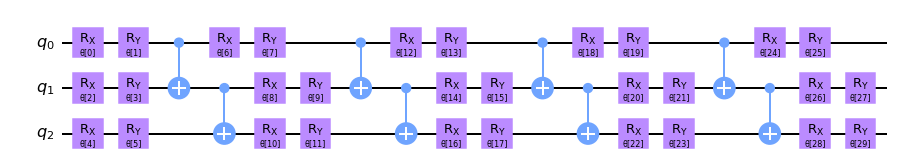
Para ello considere:
- Crear una función `ent_gate` que genere la compuerta de entrelazamiento y tenga como argumento el número de qubits.
- Los argumentos de la función `mi_ansatz` deben ser el número de qubits, el número de repeticiones y los parametros.

2) Genere un ansatz para `mi_hamiltoniano` que conste de una repetición usando esta función. Este ansatz debe ser una función que solo dependa de los parámetros y llamarse `ansatz_hamiltoniano`, para ello ocupe funciones lambda como se indica en la celda de solución.

3) Use lo previamente visto para evaluar el valor de expectación de `mi_hamiltoniano` en el estado ansatz cuando se evaluan los parámetros en $[0,\pi, 2\pi,\cdots,(npars-1)\pi]$ (npars es el número de parámetros) usando circuitos cuánticos con el backend `qasm_simulator`. Finalice con realizar el cálculo teórico y comparar resultados
   

In [10]:
#Solucion
#Parte 1
def ent_gate(self):
    for i in range(self.num_qubits-1):
        self.cx(i,i+1)
        
QuantumCircuit.ent_gate = ent_gate

def mi_ansatz( nqubits , reps , pars ):
    circ = QuantumCircuit(nqubits)
    
    for r in range(reps+1):
        for q in range(nqubits):
            circ.rx( pars[ 2*r*nqubits + 2*q ] , q )
            circ.ry( pars[ 2*r*nqubits + 2*q + 1 ] , q)
            
        if r < reps:
            circ.ent_gate()
            
    return circ
        
# Parte 2

nq = 2
reps = 1

npars = 2*nq*(reps+1)
pars = np.arange( npars ) *np.pi

ansatz_hamiltoniano = lambda x : mi_ansatz( nq , 1 , x )

#Parte 3

# Cargar instancia
qi = QuantumInstance( Aer.get_backend( "qasm_simulator") , shots = 2**7 )

# se transforma el circuito a un estado de opflow
# se transforma el hamiltoniano a una operador de medicion
# se transforma todo el objeto con PauliExpectation para poder medirlo en un circuito
# Se evaluan usando CircuitSampler

ansatz = ansatz_hamiltoniano( np.arange( npars ) * np.pi ) 
ansatz_state = of.StateFn( ansatz )
measurement_operator = of.StateFn( mi_hamiltoniano ).adjoint()

experiment = measurement_operator @ ansatz_state
pauli_circuits = of.PauliExpectation().convert( experiment ) 

expected_value = of.CircuitSampler( qi ).convert(pauli_circuits).eval().real

print("Energía es = {}".format( expected_value ) ) 
print("Teórica = {}".format( experiment.eval().real ) )

Energía es = 2.078125
Teórica = 2.0


**Ejercicio 7**

Usando todo lo aprendido anteriormente cree la función `mi_vqe(hamiltoniano,ansatz,optimizador,quantum_instance)`, cuyos argumentos sean el hamiltoniano objetivo, el ansatz, un optimizador y la instancia cuántica. Luego prosiga a minimizar `mi_hamiltoniano`.

Ocupe el optimizador que se entrega, y siga las instrucciones de como usarlo

Si necesita ayuda siga los siguientes pasos:

- Cree una función llamada `mi_med_energia(hamiltoniano,ansatz,parametros,quantum_instance)` que tenga como retorno la medición de energía
- Dentro de la función `mi_vqe` :
    - Utilize funciones `lambda` para crear la función objetivo `medicion_energía` en base a `mi_med_energia` la cual dependa solo de los parámetros mientras que las otras variables se encuentran ya evalualadas.
    ```python
    medicion_energia = lambda x: mi_medicion_energia( hamiltoniano , ansatz , quantum_instance , x )
    ```
    
    
    - Ocupe el método `minimize` del optimizador para minimizar la función objetivo `target` y finalmente retorne este último resultado

In [43]:
# Solución
from qiskit.algorithms.optimizers import SPSA
# inicialización del optimizador
# debe entregar está "opt" a la función "mi_vqe"
# Para minimizar una funcion debe hacerlo de la forma "opt.minimize(func , punto_inicial)"
# se debe proveer un punto inicial para optimizador, este puede ser aleatorio
opt = SPSA(  )

def mi_med_energia( hamiltoniano , ansatz , quantum_instance , parametros ):
    
    ansatz_state = of.StateFn( ansatz( parametros ) )
    medicion = of.StateFn( hamiltoniano ).adjoint() @ ansatz_state
    
    pauli_circs = of.PauliExpectation().convert( medicion )
    sampler = of.CircuitSampler(quantum_instance).convert( pauli_circs )
    
    return sampler.eval().real
    
    
def mi_vqe( hamiltoniano , ansatz , optimizador , quantum_instance , punto_inicial ):
    
    energia_hamiltoniano = lambda x : mi_med_energia( hamiltoniano , ansatz , quantum_instance , x )
    result = opt.minimize( energia_hamiltoniano , punto_inicial )
    
    return result
    
    

In [45]:
mi_vqe( mi_hamiltoniano , ansatz_hamiltoniano , opt , quantum_instance , np.random.randn( npars ) )

In [52]:
# Compare sus resultados con esta celda
from qiskit.algorithms import NumPyMinimumEigensolver

eig = NumPyMinimumEigensolver()
comparar = eig.compute_minimum_eigenvalue( mi_hamiltoniano )
print(comparar)

{   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([-5.08299952e-01+1.34254838e-01j,
             -2.22044605e-16-2.22044605e-16j,
              6.93889390e-17-5.55111512e-17j,
             -8.22446598e-01+2.17228891e-01j],
            dims=(2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': -2.6180339887498967}


# Qiskit Nature

Qiskit Nature es un entorno que permite resolver problemas de mecánica cuántica presentes en las ciencias naturales, como por ejemplo encontrar el estado de mínima energía de una molecula. Por estos motivos Qiskit Nature cuentas con clases que nos sirven para construir moleculas y poder leer sus características de relevancia


In [11]:
from qiskit_nature.settings import settings as qkst
qkst.dict_aux_operators=True
from qiskit_nature.drivers import Molecule
from qiskit_nature.units import DistanceUnit
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver

dist = 2.5

molecule = Molecule(
    geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]],
    charge=0, 
    multiplicity=1,
    units = DistanceUnit.ANGSTROM
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

In [12]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.mappers.second_quantization import  ParityMapper


# active space of the electronic structure problem
# see es_problem.grouped_property to see number of electrons and orbitals
transformer = ActiveSpaceTransformer(
    num_electrons=4,
    num_molecular_orbitals=3
)

es_problem = ElectronicStructureProblem( driver, 
                                        [transformer] 
                                       )
qubit_converter = QubitConverter(ParityMapper(),
                                 two_qubit_reduction=True
                                )

second_quantized_op = es_problem.second_q_ops()["ElectronicEnergy"]
pauli_hamiltonian = qubit_converter.convert( second_quantized_op,
                                            es_problem.num_particles
                                           )
print( "número de términos ={}".format( pauli_hamiltonian.primitive.size ))
print( "número de bases a medir si los agrupamos por operadores que conmutan ={}".format( len( pauli_hamiltonian.primitive.group_commuting(qubit_wise = True)  )) ) 

número de términos =100
número de bases a medir si los agrupamos por operadores que conmutan =25


In [16]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2

opt = SPSA( maxiter  = 300 )

reps = 1
nqbits = pauli_hamiltonian.num_qubits
npars = 2 * nqbits * ( reps + 1 )

par = ParameterVector( "θ" , npars )

ansatz = EfficientSU2( num_qubits=nqbits , reps =reps , entanglement = "linear" )

initial_point = np.random.randn( npars )

quantum_instance = QuantumInstance( Aer.get_backend( "qasm_simulator" , shots = 2**13 ) )

vqe = VQE( ansatz = ansatz,
          optimizer = opt,
          initial_point = initial_point,
          quantum_instance = quantum_instance
         )

results = vqe.compute_minimum_eigenvalue( pauli_hamiltonian ) 
print( results )
          

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 600,
    'eigenstate': {   '0101': 0.240035804620894,
                      '0111': 0.82915619758885,
                      '1101': 0.15934435979977452,
                      '1111': 0.4790534286486216},
    'eigenvalue': (-8.290650134716167+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[9]): 0.6409810722620956,
                              ParameterVectorElement(θ[6]): -0.7809786495901806,
                              ParameterVectorElement(θ[8]): 0.0011084854115854413,
                              ParameterVectorElement(θ[7]): -1.379545014302778,
                              ParameterVectorElement(θ[15]): 2.642361384324992,
                              ParameterVectorElement(θ[5]): -0.4855123815037993,
                              ParameterVectorElement(θ[11]): -2.1202584318151505,
                              ParameterVectorElement(θ[10]): -0.014880788802210842,
        

In [85]:
numpy_solver = NumPyMinimumEigensolver()
results =  numpy_solver.compute_minimum_eigenvalue( pauli_hamiltonian )
print( results ) 

{   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([-2.39607037e-17+1.02479678e-16j,
             -4.29620455e-16+5.11704097e-17j,
             -2.95051492e-16+4.19473290e-17j,
             -2.68093068e-16-4.92557009e-16j,
              1.83532255e-16-1.99040423e-16j,
             -8.22554106e-01-5.68331761e-01j,
              2.21379193e-04+1.52958724e-04j,
             -4.42237723e-03-3.05557704e-03j,
             -8.01029088e-17+2.73824284e-16j,
              2.21379193e-04+1.52958724e-04j,
              3.28676475e-03+2.27094216e-03j,
             -5.82121523e-05-4.02208375e-05j,
              2.53681652e-16-7.69582195e-16j,
             -4.42237723e-03-3.05557704e-03j,
             -5.82121523e-05-4.02208375e-05j,
              1.49420264e-02+1.03239752e-02j],
            dims=(2, 2, 2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': -8.922018541041307}


# Hasta Aquí


*En caso de no recordar como medir un operador de Pauli en circuito lea esta celda*


Para eso nuestro primer paso será aprender a calcular el valor de expectación de
operadores Pauli. Para eso primero tomemos el operador $Y$ y notemos que sus 
autoestados son 
$$|\lambda_\pm\rangle =\frac{|0\rangle\pm i|1\rangle}{\sqrt2}$$ 
y se escribe de la siguiente forma
$$Y= |\lambda_+\rangle\langle\lambda_+|-|\lambda_-\rangle\langle\lambda_-|$$
Por otro lado recordamos que los estados $|\lambda_\pm\rangle$ pueden ser expresados como
$$|\lambda_+\rangle = SH|0\rangle$$
$$|\lambda_-\rangle = SH|1\rangle$$


luego el valor de expectación de $Y$ es dado por 
$$ \langle\psi|Y|\psi\rangle
= |\langle \lambda_+ | H S |\psi\rangle|^2 - |\langle \lambda_- | H S |\psi\rangle|^2
= |\langle 0 | H S |\psi\rangle|^2 - |\langle 1 | H S |\psi\rangle|^2
$$

Lo cual nos indica que para medir el valor de expectación de $Y$ debemos aplicar el 
circuito $HS$ y proseguir a medir en la base standard, donde las probabilidades de 
medir 0 y 1 deben ser ocupada como muestra la formula superior




*Ejercicio* Calcule a mano que compuertas serían las necesarias para medir la expectación de los  operadores $X$ y $Z$ que implementen los respectivos circuitos:

